In [ ]:

#-- Descomprimimos el dataset
!rm -r mnist
!unzip mnist.zip

In [4]:
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

train_files[0]

'./mnist/train/0/3565.png'

In [5]:
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(6000, 2000, 992)

In [11]:
train_files10 = train_files[:600]
print(len(train_files10))
train_files20 = train_files[:1200]
print(len(train_files20))
train_files50 = train_files[:3000]
print(len(train_files50))
train_files80 = train_files[:4800]
len(train_files80)


600
1200
3000


4800

Para train 100% y valid 100%

In [63]:
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))


N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

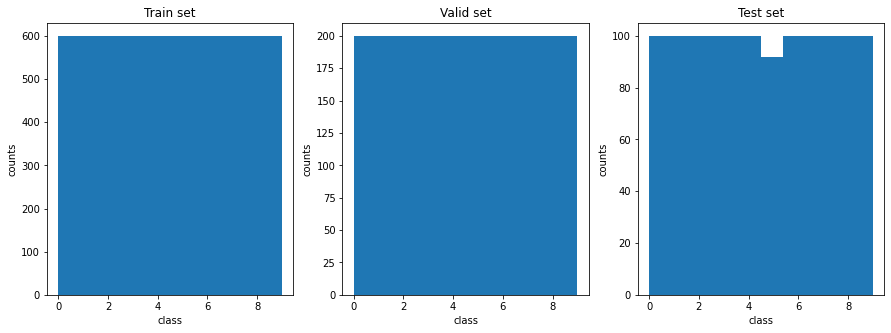

In [64]:
#--- Visualizamos la distribución de clases en cada subset
from PIL import Image
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(np.sort(Y_train))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Train set')

plt.subplot(1,3,2)
plt.hist(np.sort(Y_valid))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Valid set')

plt.subplot(1,3,3)
plt.hist(np.sort(Y_test))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Test set')

plt.show()

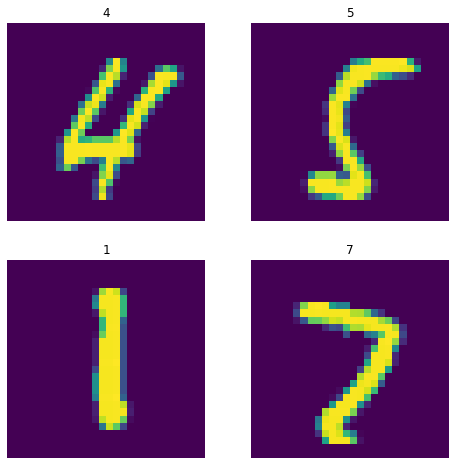

In [14]:
#-- Visualizamos los datos
fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [65]:
#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

#--- Definimos una ANN con dos capas ocultas lineales de 100 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),  
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
from sklearn.metrics import f1_score # Nueva métrica (La revisaremos la próóxima sesión)

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

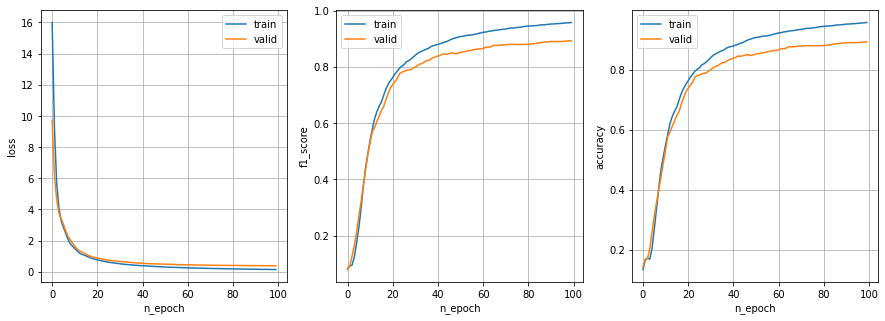

In [67]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [68]:
#-- Evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.3351304829120636, f1: 0.897917718371821, acc: 0.8981854915618896


Para train. 10% y valid 100%

In [19]:
from PIL import Image

N_train = len(train_files10)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files10):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))


N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

In [28]:
#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

#--- Definimos una ANN con dos capas ocultas lineales de 100 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),  
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
from sklearn.metrics import f1_score # Nueva métrica (La revisaremos la próóxima sesión)

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

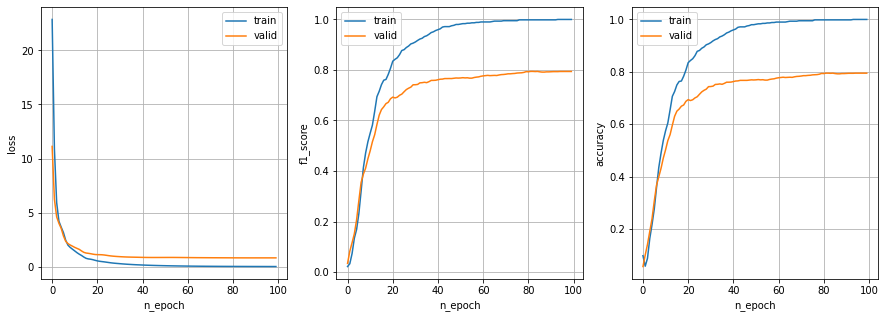

In [30]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [23]:
#-- Evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 1.8107762336730957, f1: 0.8256423464804609, acc: 0.8266128897666931


Para train 20% y valid 100%

In [31]:
from PIL import Image

N_train = len(train_files20)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files10):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))


N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

#--- Definimos una ANN con dos capas ocultas lineales de 100 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),  
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
from sklearn.metrics import f1_score # Nueva métrica (La revisaremos la próóxima sesión)

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

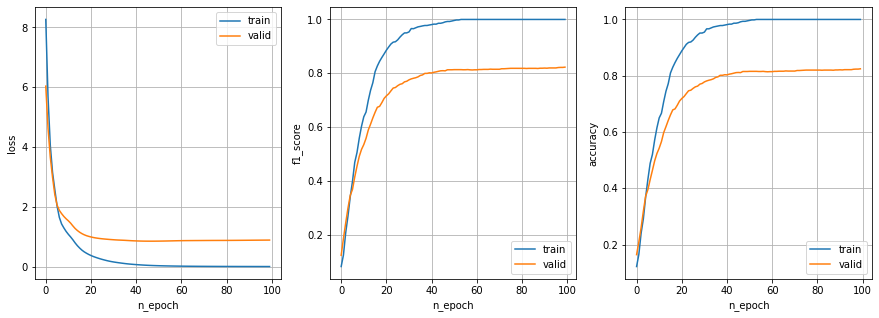

In [33]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [34]:
#-- Evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.839064359664917, f1: 0.8161649254609218, acc: 0.819556474685669


Para train 50%. y valid 100%

In [35]:
from PIL import Image

N_train = len(train_files50)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files50):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))


N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

#--- Definimos una ANN con dos capas ocultas lineales de 100 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),  
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
from sklearn.metrics import f1_score # Nueva métrica (La revisaremos la próóxima sesión)

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

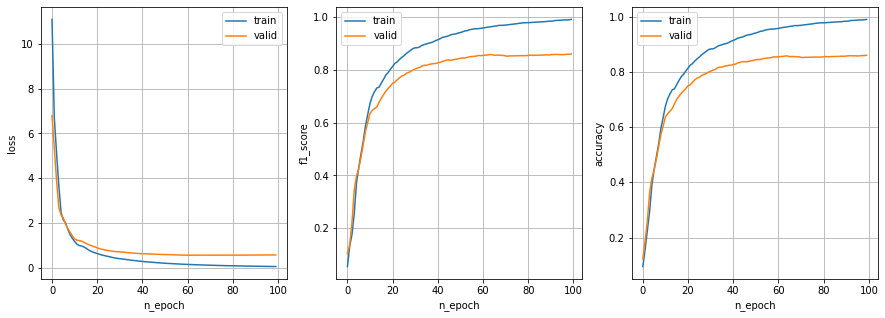

In [37]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [38]:
#-- Evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.4755757451057434, f1: 0.8873065823168407, acc: 0.8881048560142517


Para train 80% y valid 100%

In [39]:
from PIL import Image

N_train = len(train_files80)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files80):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))


N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

#--- Definimos una ANN con dos capas ocultas lineales de 100 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),  
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
from sklearn.metrics import f1_score # Nueva métrica (La revisaremos la próóxima sesión)

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

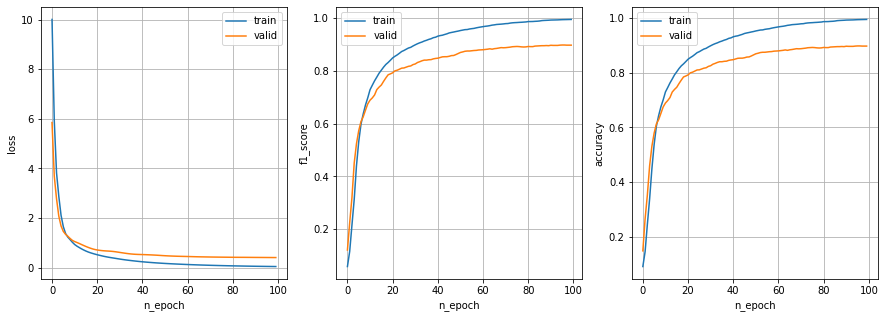

In [41]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [42]:
#-- Evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.3933998942375183, f1: 0.8864189568638026, acc: 0.8870967626571655


Análisis teniendo en cuenta el cambio de porcentaje en los tamaños de entrenamiento. 



*   A primera vista, se puede ver como a medida que se usa un porcentaje mayor de entrenamiento el acc es más alto. Por ejemplo para 10% fue: 0.82 y para 80% fue:  0.887; y los valores para el loss fue 1.8 y 0.39 correspondiente. Lo que también afirma que es mejor usar un porcentaje grande de entrenamiento. 
*   Esto afirma que es bueno usar muchos datos de entrenamiento. Aunque deja en cuestión que la diferencia en el ACC no es mucha. ¿A qué se le atribuir esto?, tal vez el modelo de ANN utilizado.  



**Cambiando el tamaño de validación**

- cabe resaltar que el de valid 100% y train. 100% se encuentra al inicio

In [43]:
valid_files10 = train_files[:200]
print(len(valid_files10))
valid_files20 = train_files[:400]
print(len(valid_files20))
valid_files50 = train_files[:1000]
print(len(valid_files50))
valid_files80 = train_files[:1600]
print(len(valid_files80))


200
400
1000
1600


train 100% y valid 10%

In [46]:
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))


N_valid = len(valid_files10)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files10):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

#--- Definimos una ANN con dos capas ocultas lineales de 100 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),  
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
from sklearn.metrics import f1_score # Nueva métrica (La revisaremos la próóxima sesión)

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

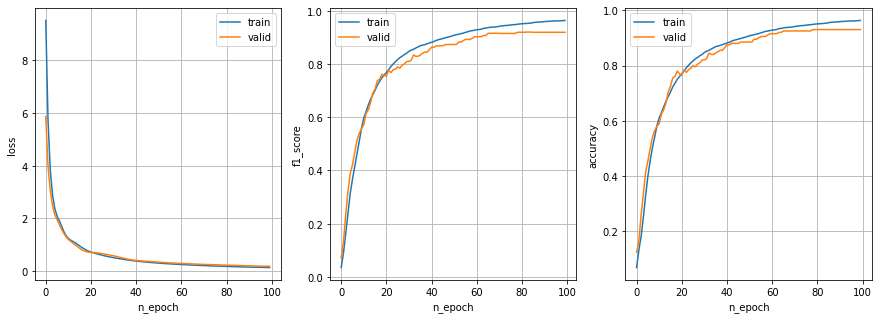

In [48]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [49]:
#-- Evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))


loss: 0.3527073264122009, f1: 0.9064781909677218, acc: 0.90625


Para valid 20% y train 100%

In [ ]:
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))


N_valid = len(valid_files20)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files20):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

#--- Definimos una ANN con dos capas ocultas lineales de 100 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),  
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

from sklearn.metrics import f1_score # Nueva métrica (La revisaremos la próóxima sesión)

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

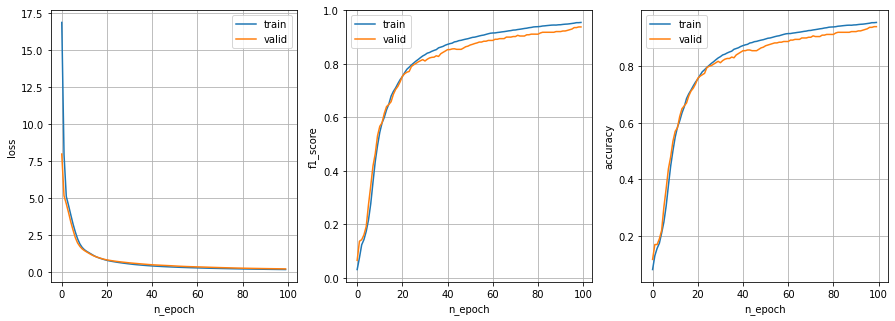

In [52]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [61]:
#-- Evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))


loss: 0.3435595631599426, f1: 0.9008734105579748, acc: 0.9012096524238586


Para train 100% y valid 50%

In [ ]:
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))


N_valid = len(valid_files50)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files50):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

#--- Definimos una ANN con dos capas ocultas lineales de 100 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),  
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

from sklearn.metrics import f1_score # Nueva métrica (La revisaremos la próóxima sesión)

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

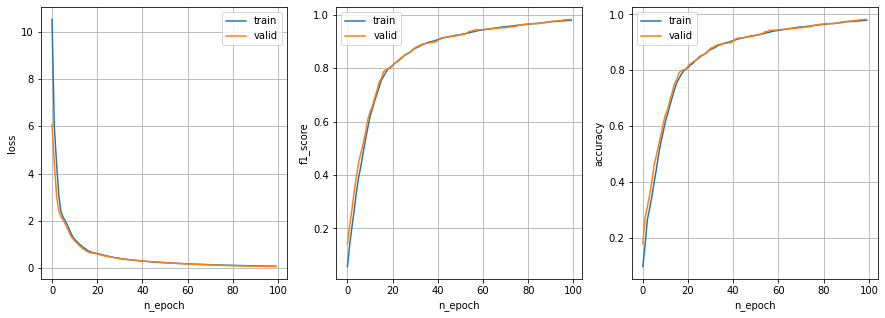

In [55]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [62]:
#-- Evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))


loss: 0.3435595631599426, f1: 0.9008734105579748, acc: 0.9012096524238586


Para train 100 y valid 80

In [ ]:
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))


N_valid = len(valid_files80)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files80):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

#--- Definimos una ANN con dos capas ocultas lineales de 100 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),  
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

from sklearn.metrics import f1_score # Nueva métrica (La revisaremos la próóxima sesión)

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

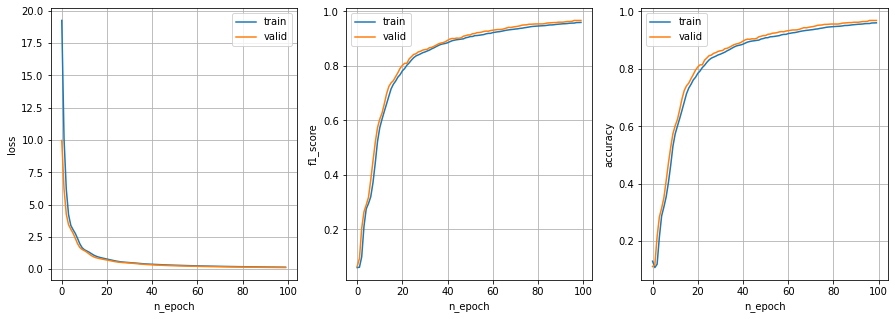

In [58]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [59]:
#-- Evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))


loss: 0.3435595631599426, f1: 0.9008734105579748, acc: 0.9012096524238586


**Análisis para porcentajes diferentes de valid**

Acontinuación se presenta los valores de loss, f1 y ACC 

*   100 valid, 0.3351304829120636, f1: 0.897917718371821, acc: 0.8981854915618896
*   10 valid, loss: 0.3527073264122009, f1: 0.9064781909677218, acc: 0.90625
*   20 valid, loss: 0.3435595631599426, f1: 0.9008734105579748, acc: 0.9012096524238586
*  50 valid, loss: 0.3273859918117523, f1: 0.9118818473947728, acc: 0.9122983813285828
*   80 valid, loss: 0.3435595631599426, f1: 0.9008734105579748, acc: 0.9012096524238586


Ahora bien, a primera vista se puede ver que para todos los porcentajes los tres valores (loss, f1 y ACC) mantienen números similares. Lo que sugiere que la cantidad de valores de validación no afecta en gran medida el resultado. Sino que, como se pudo ver en los cambios de datos de entrenamiento, se tendrán cambios en el proceso si se reduce o aumenta el train set 







